In [15]:
from typing import Union, Iterable, Hashable, Callable, List
from functools import partial
import re

import pandas as pd
import xarray as xr
from pyproj import Transformer
from datetime import datetime, timedelta
import pylab as plt
from pathlib import Path

In [16]:
def preprocess_nc(
    ds: xr.Dataset,
    regexp: str = "id_(.+?)_",
    dim: str = "exp_id",
    drop_vars: Union[str, Iterable[Hashable], Callable[[xr.Dataset], Union[str, Iterable[Hashable]]]] = ["nv4"],
    drop_dims: List[str] = ["nv4"],
) -> xr.Dataset:
    """
    Add experiment 'exp_id' to the dataset and drop specified variables and dimensions.

    This function adds an experiment id ('exp_id') to the dataset, extracted from the source encoding
    using the provided regular expression. It then drops the specified variables and dimensions from the dataset.

    Parameters
    ----------
    ds : xr.Dataset
        The dataset to be preprocessed.
    regexp : str, optional
        The regular expression used to extract the experiment id from the source encoding, by default "id_(.+?)_".
    dim : str, optional
        The name of the dimension to be added to the dataset, by default "exp_id".
    drop_vars : Union[List[str], None], optional
        The variables to be dropped from the dataset, by default None.
    drop_dims : List[str], optional
        The dimensions to be dropped from the dataset, by default ["nv4"].

    Returns
    -------
    xr.Dataset
        The preprocessed dataset.
    """

    m_id_re = re.search(regexp, ds.encoding["source"])
    ds.expand_dims(dim)
    assert m_id_re is not None
    m_id: Union[str, int]
    try:
        m_id = int(m_id_re.group(1))
    except:
        m_id = str(m_id_re.group(1))
    ds[dim] = m_id
    return ds.drop_vars(drop_vars, errors="ignore").drop_dims(drop_dims, errors="ignore")


In [17]:
jib = xr.open_dataset("/mnt/storstrommen/pism-greenland/data_sets/ocean/fldmean_jib_ocean_forcing_id_ctrl_1980_2020.nc").squeeze()

In [18]:
ps = Path("/mnt/storstrommen/pism-greenland/data_sets/ocean/").glob("MAR3.9_*_ocean_1960-2100_v4.nc")
ps = [p for p in ps if "ctrl_proj" not in p.name]
ds = xr.open_mfdataset(ps, 
                       parallel=True,
                       chunks="auto",
                       preprocess=partial(preprocess_nc, regexp="MAR3.9_(.+?)_ocean"),
                       combine="nested",
                       concat_dim="exp_id")


/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/xarray/core/dataset.py:4743: UserWarning: No index created for dimension exp_id because variable exp_id is not a coordinate. To create an index for exp_id, please first call `.set_coords('exp_id')` on this object.
  warnings.warn(


In [19]:
recon = xr.open_dataset("/home/andy/Downloads/FinalOutput/generatedTF_allglaciersinshore_MIROCES2L_MembersAverage_hist2100ssp585.nc")

In [20]:
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    rem = decimal_year - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)

    return result

In [21]:
decimal_year = recon.time.to_numpy()
datetimes = [decimal_year_to_datetime(year) for year in decimal_year]
glacier = recon.Glacier.to_numpy()
realization = recon.RealizationNumber.to_numpy()
theta_ocean = recon.TF.to_numpy()
lat = recon.lat.to_numpy()
lon = recon.lon.to_numpy()

r_ds = xr.Dataset(coords={"time": datetimes, "glacier": glacier, "realization": realization},
                 data_vars={"lat": (["glacier"], lat),
                            "lon": (["glacier"], lon),
                            "theta_ocean": (["realization", "glacier", "time"], theta_ocean, {"units": "K"})})

In [22]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3413")

In [23]:
x, y = transformer.transform(r_ds.lat, r_ds.lon)
X = xr.DataArray(x, coords={"glacier": glacier}, name="x")
Y = xr.DataArray(y, coords={"glacier": glacier}, name="y")
r_ds = xr.merge([r_ds, X, Y])

In [24]:
gcms = ds.sel(time=slice("1980-01-01", "2010-01-01"))
reanalysis = r_ds.sel(time=slice("1980-01-01", "2010-01-01")).rolling(time=13).mean()

/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


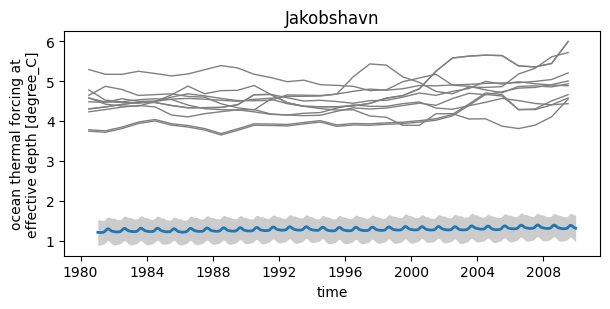

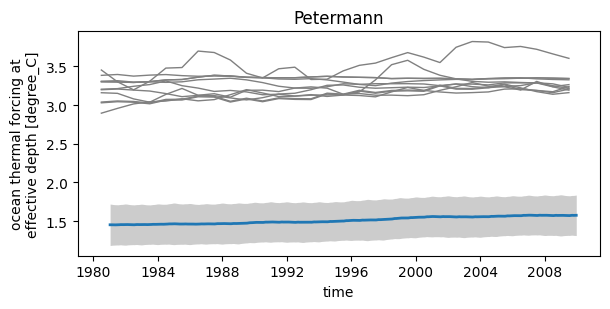

In [35]:
for k in [86, 161]:
    reanalysis_glacier = reanalysis.isel(glacier=k)
    pos = {"x": reanalysis_glacier.x, "y": reanalysis_glacier.y}
    gcm_theta = gcms.sel(pos, method="nearest").theta_ocean
    reanalysis_theta = reanalysis_glacier.theta_ocean
    reanalysis_theta_mean = reanalysis_theta.mean(dim="realization")
    reanalysis_theta_std = reanalysis_theta.std(dim="realization")
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 3.2))
    ax.fill_between(reanalysis_theta_mean.time, reanalysis_theta_mean - reanalysis_theta_std, reanalysis_theta_mean + reanalysis_theta_std, 
                    color="k", alpha=0.20, lw=0)
    reanalysis_theta_mean.plot.line(lw=2, ax=ax)
    gcm_theta.plot.line(x="time", hue="exp_id", ax=ax, color="0.5", lw=1, add_legend=False)        
    glacier_name = reanalysis_theta.glacier.values
    ax.set_title(glacier_name)
    fig.tight_layout()
    fig.savefig(f"{glacier_name}.pdf")

/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


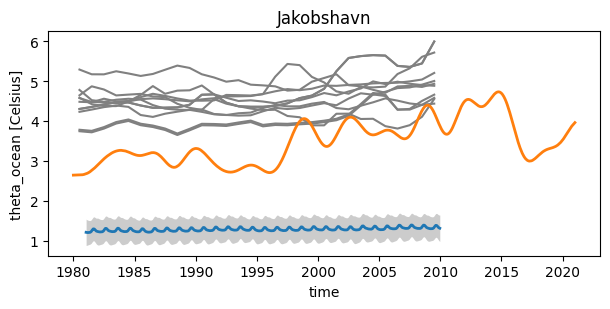

In [36]:
    k = 86
    reanalysis_glacier = reanalysis.isel(glacier=k)
    pos = {"x": reanalysis_glacier.x, "y": reanalysis_glacier.y}
    gcm_theta = gcms.sel(pos, method="nearest").theta_ocean
    reanalysis_theta = reanalysis_glacier.theta_ocean
    reanalysis_theta_mean = reanalysis_theta.mean(dim="realization")
    reanalysis_theta_std = reanalysis_theta.std(dim="realization")
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 3.2))
    ax.fill_between(reanalysis_theta_mean.time, reanalysis_theta_mean - reanalysis_theta_std, reanalysis_theta_mean + reanalysis_theta_std, 
                    color="k", alpha=0.20, lw=0)
    reanalysis_theta_mean.plot.line(lw=2, ax=ax)
    gcm_theta.plot.line(x="time", hue="exp_id", color="0.5", ax=ax, add_legend=False)        
    jib.theta_ocean.plot.line(hue="exp_id", ax=ax, lw=2)
    glacier_name = reanalysis_theta.glacier.values
    ax.set_title(glacier_name)
    fig.tight_layout()
    fig.savefig(f"{glacier_name}.pdf")


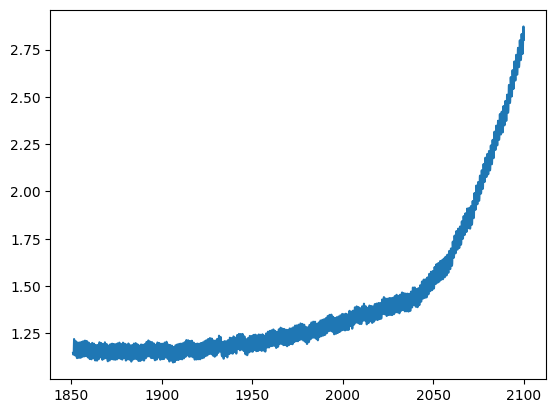

In [80]:
time = recon.time
plt.figure()
tf = recon.isel(glacierDim=86).TF.mean(dim="realizDim").rolling(timeDim=13).mean()
plt.plot(time, tf)

In [27]:
for k, g in enumerate(reanalysis.glacier):
    print(k, g.values)

0 APBernstorff
1 Academy
2 Adams
3 Akullersuup
4 Akullikassaap
5 AkullikassaapE
6 AkullikassaapW
7 Alangorliup
8 Alison
9 AnorituupKangerlua
10 AnorituupKangerluaS
11 Apuseeq
12 ApuseeqN
13 Apuseerajik
14 Avannarleq
15 Borggraven
16 Bowdoin
17 Brede
18 CHOstenfeld
19 Carlos
20 CarlosW
21 Charcot
22 Cornell
23 CornellN
24 Courtauld
25 Danell
26 DanellS
27 DanellSS
28 DanellSSS
29 DaugaardJensen
30 DeceptionOCN
31 DeceptionOCS
32 Dendrit
33 DendritS
34 Diebitsch
35 Dietrichson
36 DockerSmith
37 DockerSmithE
38 DockerSmithW
39 Dodge
40 Eielson
41 EqalorutsitKangilliit
42 EqalorutsitKilliit
43 EqalorutsitKilliitE
44 EqipSermia
45 FGraae
46 Farquhar
47 Fimbul
48 Frederiksborg
49 Gade
50 GerarddeGeer
51 Graulv
52 GraulvE
53 GyldenloveN
54 GyldenloveS
55 Hagen
56 HaraldMoltke
57 Harder
58 Hart
59 Hayes
60 HayesM
61 HayesN
62 HayesNN
63 HayesNorth
64 HayesSS
65 Heilprin
66 Heimdal
67 Heinkel
68 Helheim
69 Helland
70 HellandE
71 HellandW
72 HerlufTrolleN
73 HerlufTrolleS
74 Hisinger
75 Hubbard


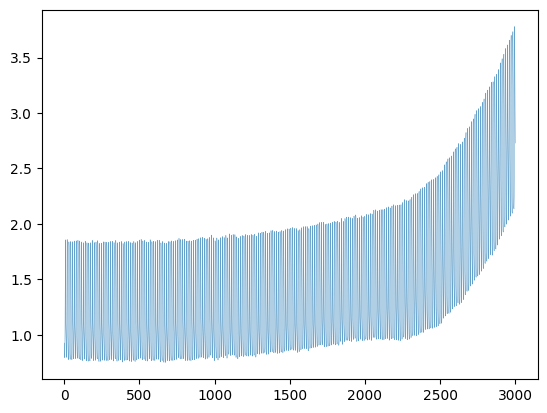

In [77]:
plt.plot(tf, lw=0.25)